In [1]:
import numpy as np
from dsp.pll import PLL_2
from dsp.fir import WSFilter
from dsp.decoding import SymbolDecoder
from dsp.agc import AGC
from dsp.am import AMDemodulator
from exp_utils import read_real, plot_some, welch

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join
root_path = os.getenv('RADIO_PATH', '.')

In [3]:
# source: rtl_fm -M fm -s 171000 -f 104105000
data_path = join(root_path, 'data/rds')
rds = read_real(data_path, dtype=np.int16).astype(np.double)

In [4]:
rds = rds.astype(np.double)

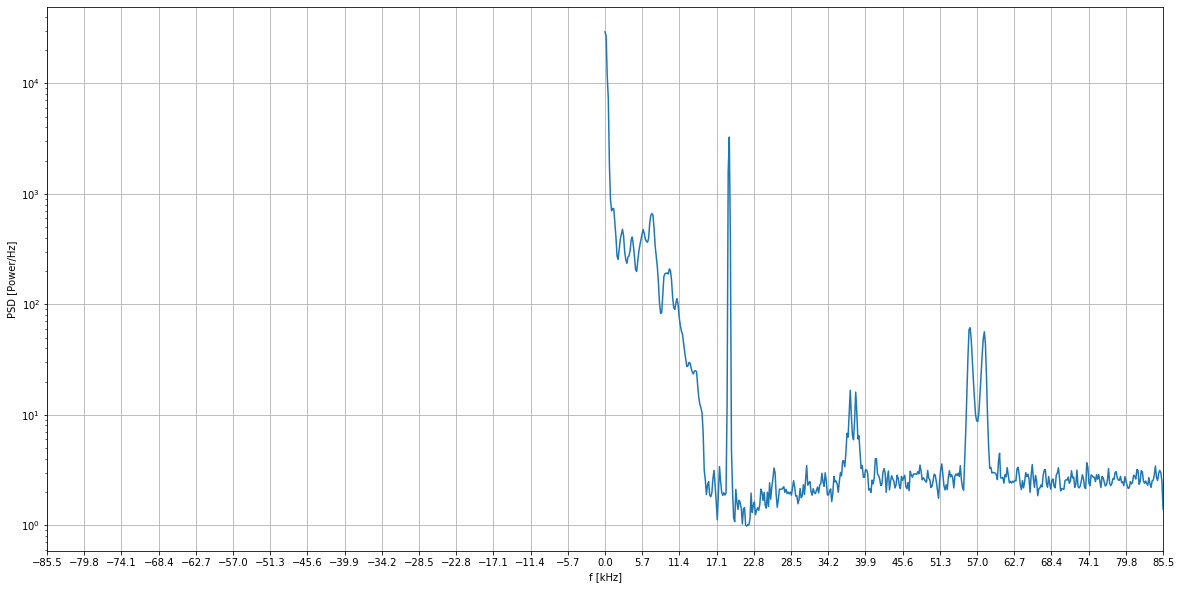

In [5]:
welch(rds, 171000)

In [6]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

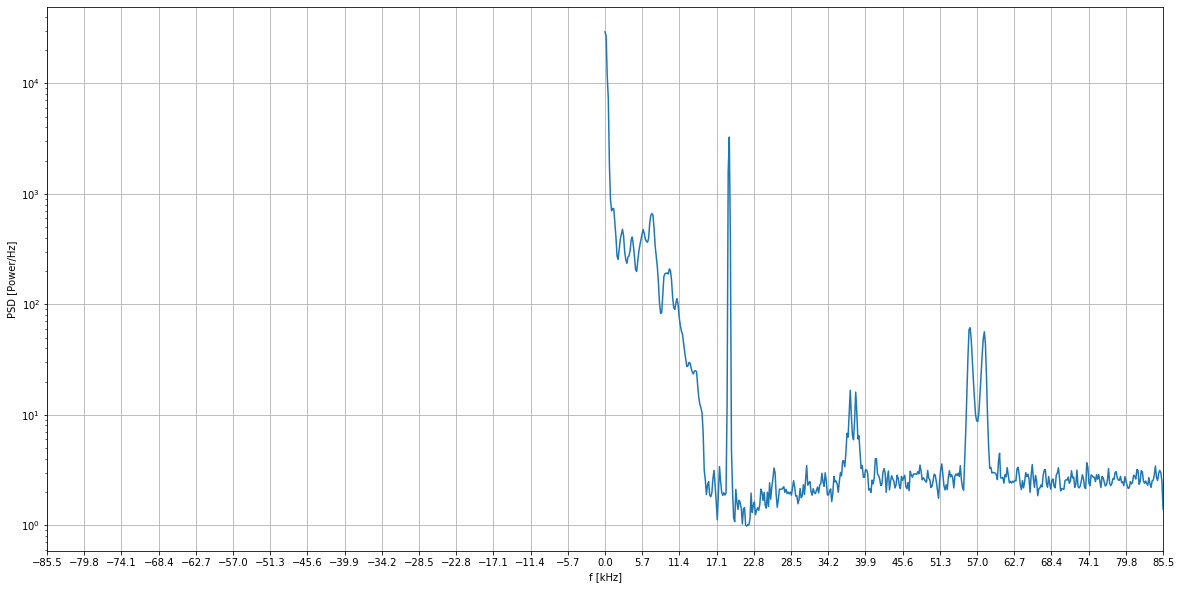

In [7]:
sample_rate = 171000
welch(rds, sample_rate)

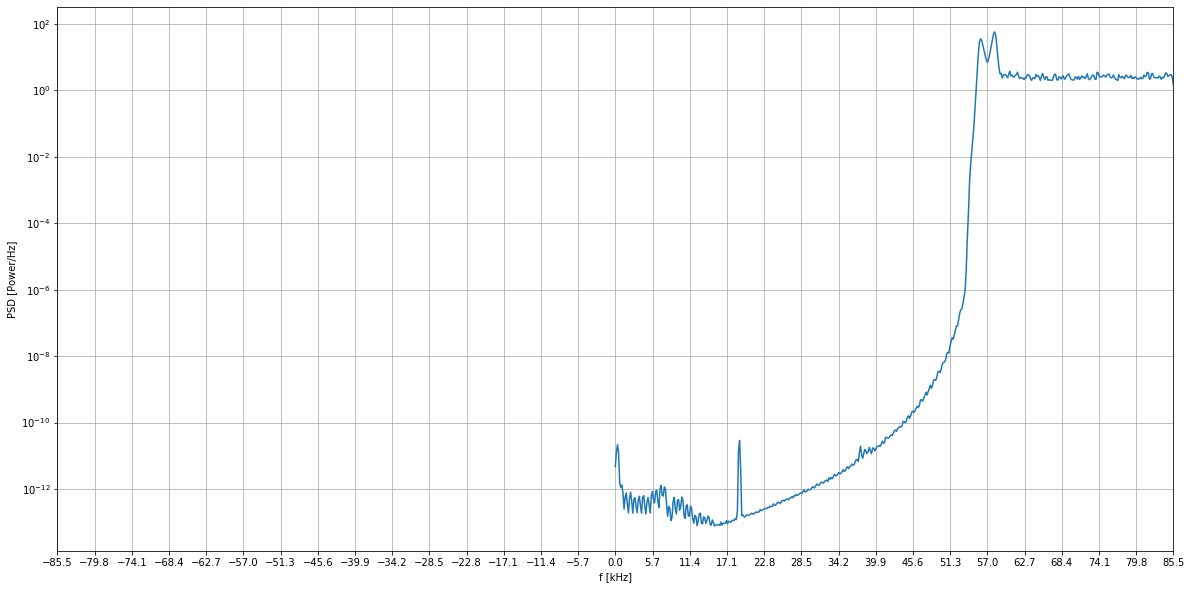

In [8]:
lp = WSFilter(257, 1, 59500 / sample_rate, lowpass=True)
hp = WSFilter(257, 1, 55500 / sample_rate, lowpass=False)
rds_w = hp.real_run(rds)
welch(rds_w, sample_rate)

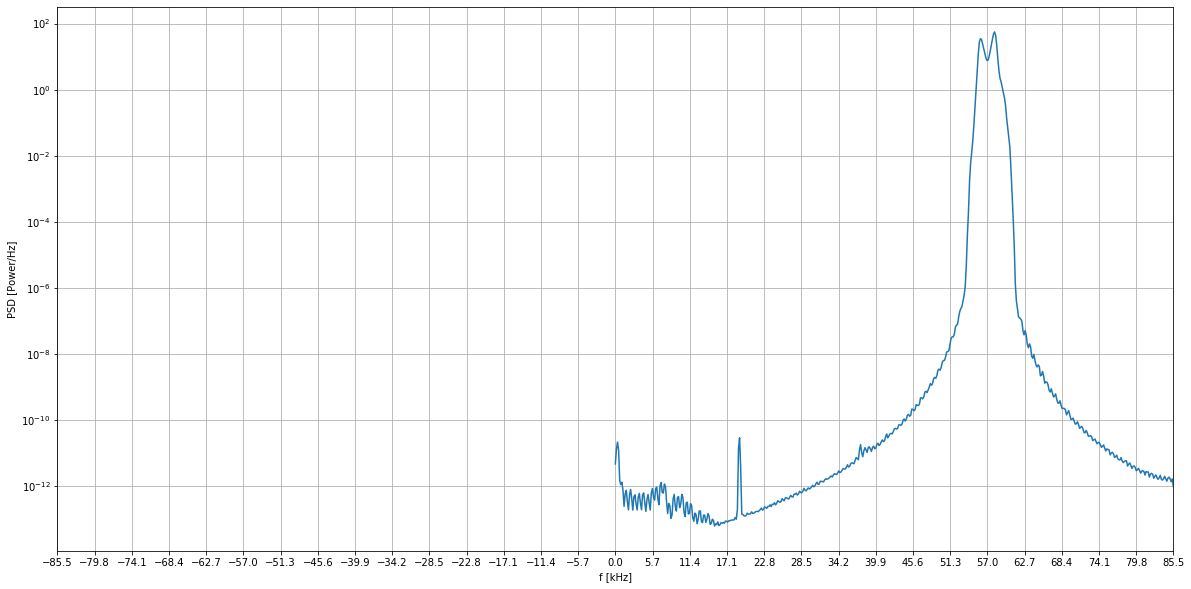

In [9]:
rds_ww = lp.real_run(rds_w)
welch(rds_ww, sample_rate)

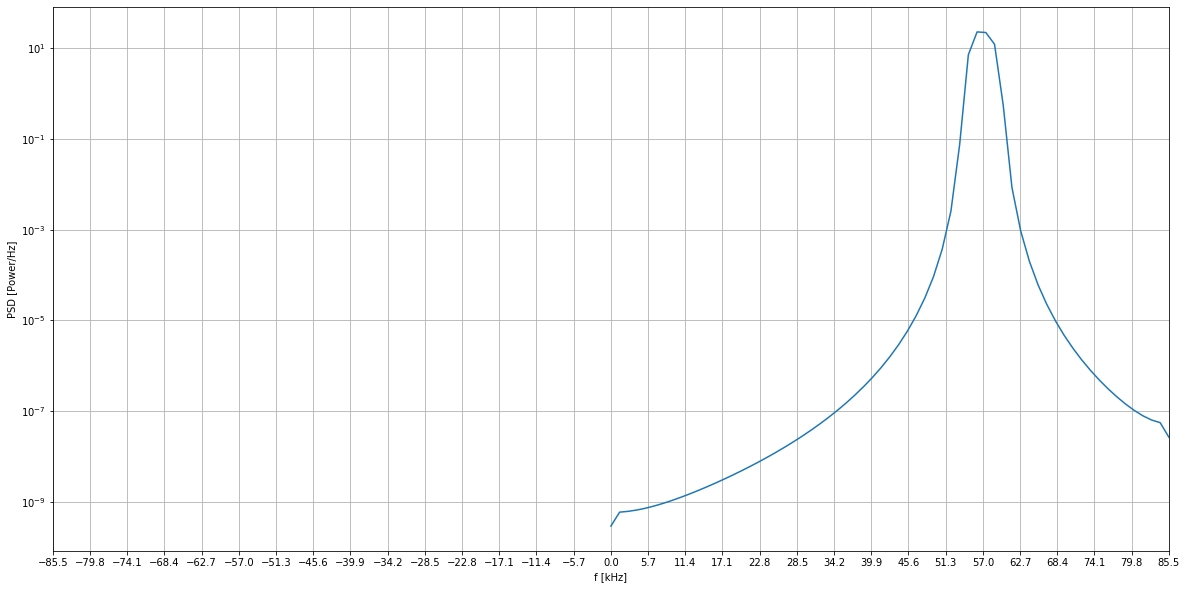

In [10]:
rds_band = butter_bandpass_filter(rds, 55500, 58500, sample_rate)
welch(rds_band, sample_rate, nper=128)

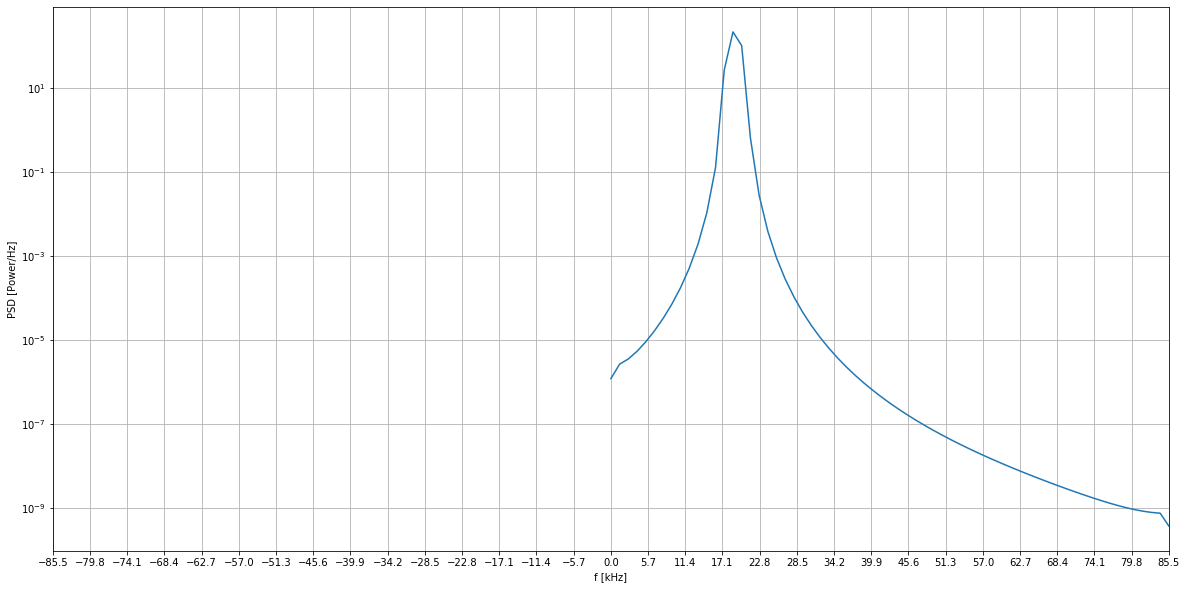

In [11]:
pilot_band = butter_bandpass_filter(rds, 18950, 19050, sample_rate)
welch(pilot_band, sample_rate, nper=128)

In [12]:
fs = 171000

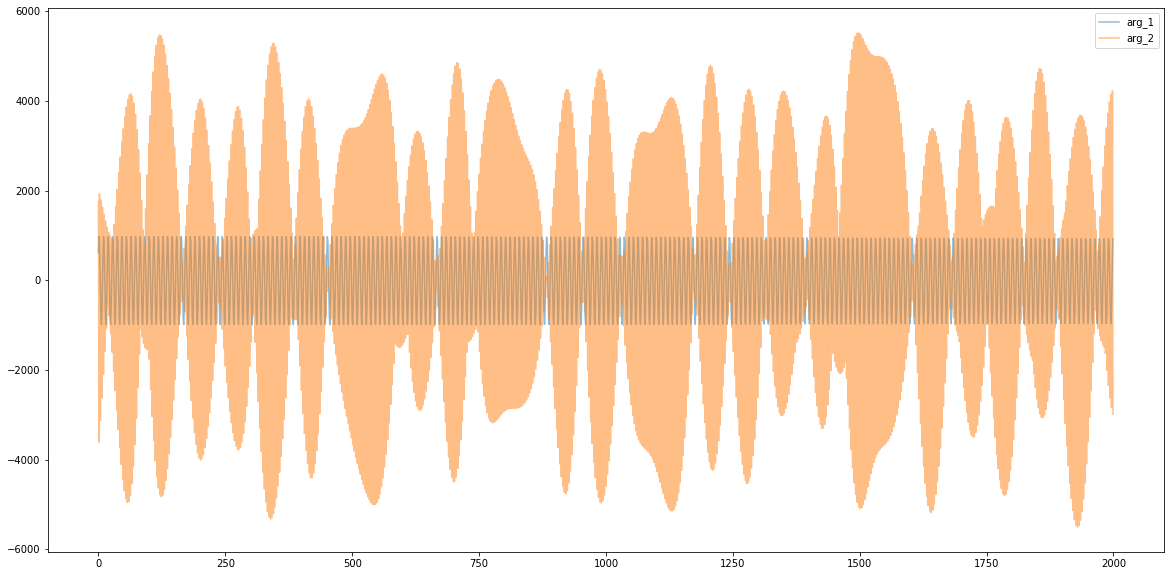

In [13]:
plot_some([pilot_band, 10 * rds_ww], 61000, 2000)

In [14]:
gain = 0.08
alpha2 = 0.2
agc2 = AGC(gain, alpha2)
agc_pilot = agc2.run(pilot_band)

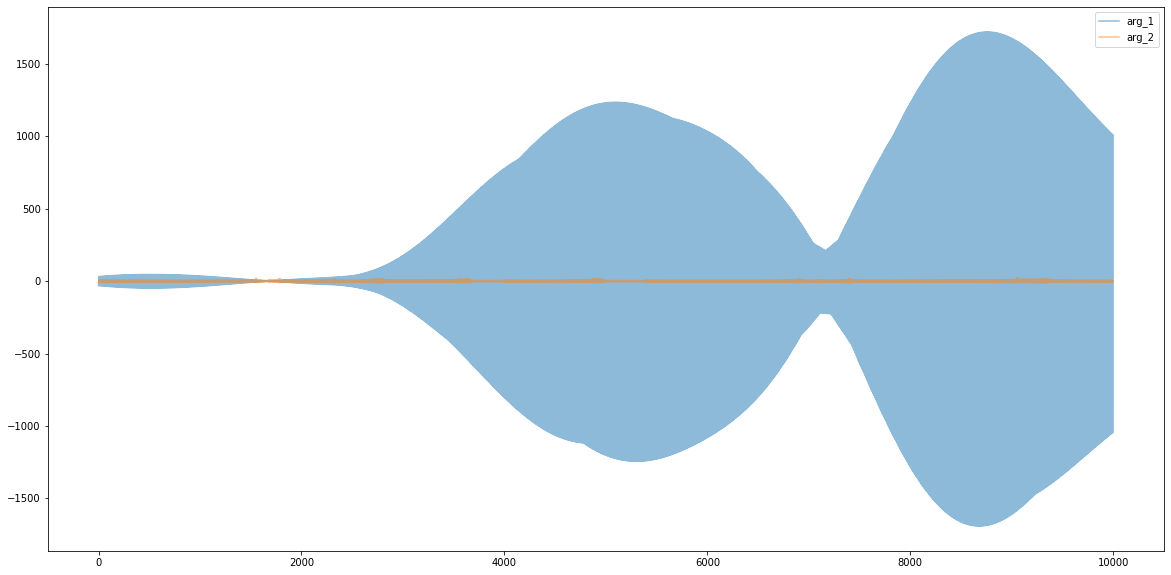

In [15]:
plot_some([pilot_band, agc_pilot], 10000, 10000)

In [16]:
fq = 19000
pll = PLL_2(fq=fq, fs=fs, Bn=0.01)

locked_pilot_phase_agc, agc_errors, agc_corrs = pll.run(agc_pilot)
locked_carrier_agc = np.array([np.cos(p) for p in locked_pilot_phase_agc])

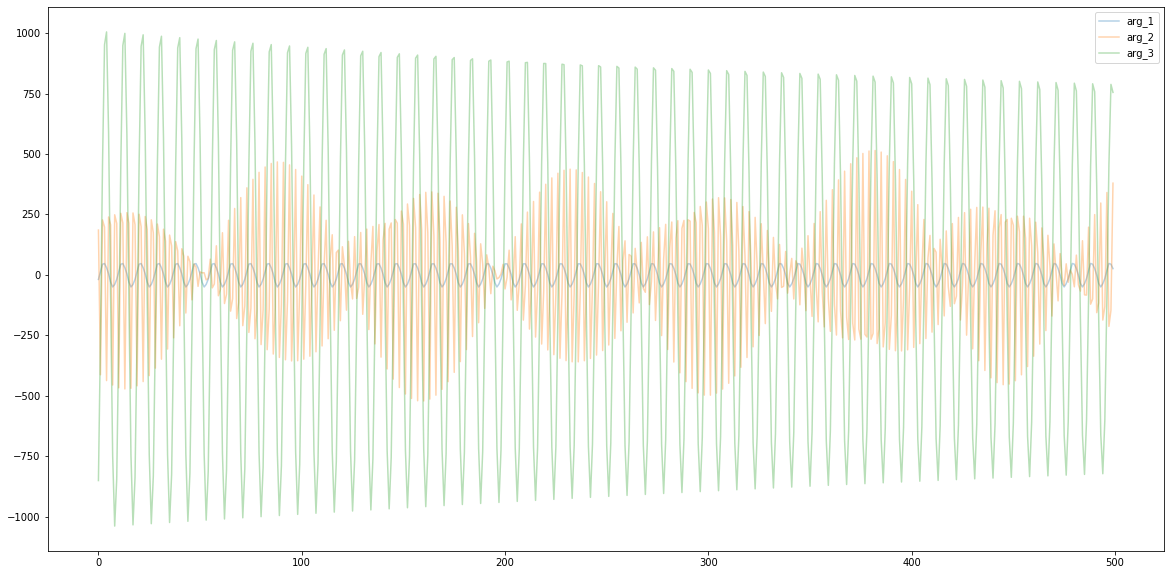

In [17]:
plot_some([50 * locked_carrier_agc, rds_ww, pilot_band], 20000, 500)

Noticed:
  * Phase error goes wild when amplitude increases (obviously, phase error detector depends on the phase - simple multiplication).
  * Applying AGC to pilot before locking the loop helps TREMENDOUSLY. 

In [18]:
reference_rds_carrier = np.array([np.cos(3 * p) for p in locked_pilot_phase_agc])

In [19]:
M = 1
am_demod = AMDemodulator(4800, fs, M, agc=False)
rds_demod = am_demod.run(rds_band, reference_rds_carrier)

In [20]:
rds_demod.shape

(3323875,)

In [21]:
rds_band.shape[0] - 256

3323875

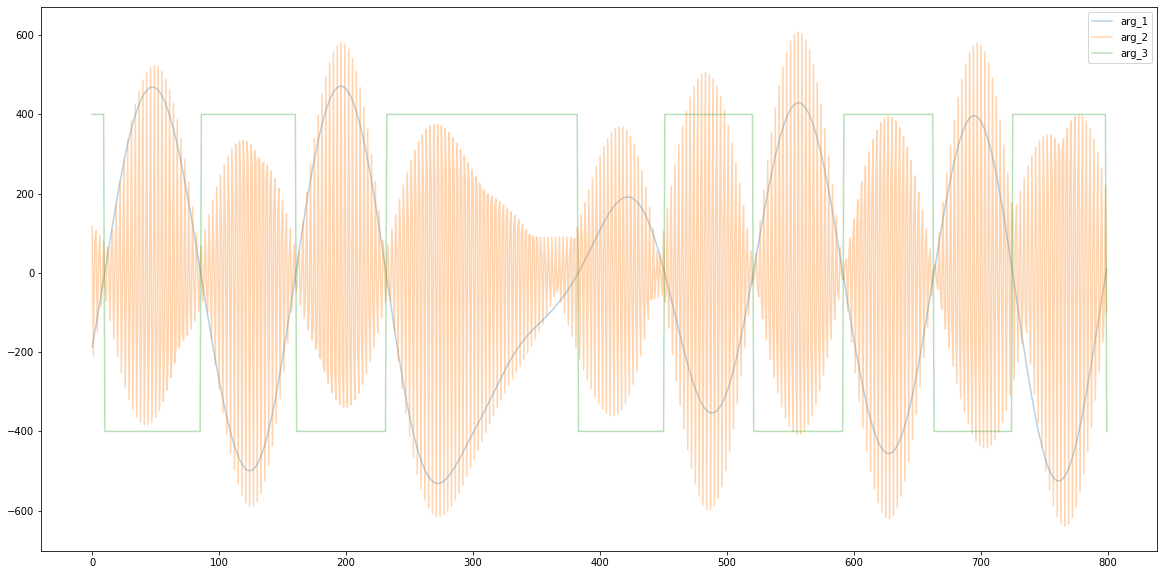

In [22]:
# plot_some([rds_demod, rds_band[128:], 400 * np.sign(rds_demod)], 61070, 1200)  # TODO: why 128??
plot_some([-rds_demod, rds_band[128:], 400 * np.sign(rds_demod)], 161070, 800)

In [23]:
np.save(joined(root_path, 'data/rds_am_demodulated'), rds_demod)

NameError: name 'joined' is not defined